# Wasserstein constrained ETEL

In [1]:
import time
import numpy as np
from optimal_transport_1d import OptimalTransport1D
from data_generator_GM import generate_GM_data
from wc_ETEL import wc_ETEL
from wc_ETEL_GM import wc_ETEL_GM
import matplotlib.pyplot as plt
from scipy.stats import beta
from numpy import log, exp
from scipy.stats import norm, gamma, wishart
import arviz as az

In [2]:
X_data = generate_GM_data()

In [3]:
start_time = time.time()

In [4]:
masses, log_likelihood = wc_ETEL(theta0=0, sigma0=1, lamda=5, data=X_data)

In [5]:
time1 = time.time()
print(f"\nRuntime: {time1 - start_time:.2f} seconds")


Runtime: 91.64 seconds


In [6]:
# The above data size is 100 while the original code for N was 300; changed to 100
X = X_data
N = len(X)
masses = np.ones(N) / N

rho0 = lambda x: 6 * x * (1 - x)

eta = 1e-3
maxiter = 3000

for i in range(maxiter):
    ot = OptimalTransport1D(X, masses, rho0, L=1.0)
    ot.update_weights(maxIter=1, verbose=False)
    ww = ot.weights
    
    masses1 = masses + eta * (-1 - np.log(N * masses) - 2 * 5 * ww)
    
    temp = np.max(np.where((masses1 + 1 / (np.arange(1, N + 1)) * (1 - np.cumsum(masses1))) > 0)) + 1
    right_shift = (1 / temp) * (1 - np.cumsum(masses1)[temp - 1])
    masses1 = masses1 + right_shift
    masses1[masses1 < 0] = 0
    
    err = np.sum((masses - masses1) ** 2)
    if err <= 1e-50:
        break

    # print(f"Iteration {i}: Error = {err:.2e}")
    masses = masses1

In [7]:
# error is 0 because 1e-50 is too small and just 0 for the machine
print(f"Final error after convergence: {err:.2e}")
time2 = time.time()
print(f"\nRuntime: {time2 - time1:.2f} seconds")

Final error after convergence: 0.00e+00

Runtime: 6.47 seconds


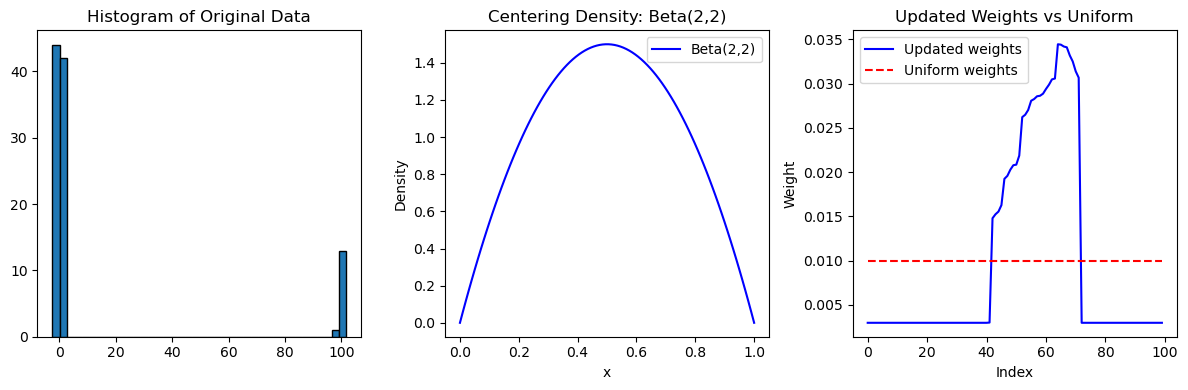

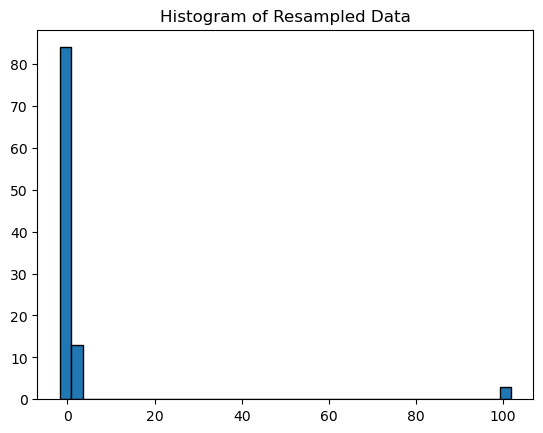

In [8]:
# 1. Histogram of original data
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(X_data, bins=40, edgecolor='black')
plt.title("Histogram of Original Data")

# 2. Plot centering density Beta(2,2)
grid = np.linspace(0, 1, 100)
plt.subplot(1, 3, 2)
plt.plot(grid, beta.pdf(grid, 2, 2), label='Beta(2,2)', color='blue')
plt.title("Centering Density: Beta(2,2)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()

# 3. Plot updated weights vs uniform
plt.subplot(1, 3, 3)
plt.plot(masses1, label='Updated weights', color='blue')
plt.plot(np.ones(N) / N, label='Uniform weights', color='red', linestyle='--')
plt.title("Updated Weights vs Uniform")
plt.xlabel("Index")
plt.ylabel("Weight")
plt.legend()

plt.tight_layout()
plt.show()

# 4. Resample using updated weights
X_data_tilde = np.random.choice(X_data, size=N, p=masses1, replace=True)

# 5. Histogram of resampled data
plt.hist(X_data_tilde, bins=40, edgecolor='black')
plt.title("Histogram of Resampled Data")
plt.show()

In [9]:
N = 100; d = 1
Alpha = 5
lamda = 3

## use the following part for simulations for a grid of sample size
# Alpha = rep(2, d)
# N_grid = c(100, 200, 300, 500)
# BF = matrix(NA, nrow = length(N_grid), ncol = 3)
# colnames(BF) <- c("Sample size", "M1", "M2")

#### Simulation control
# epsilon = 2.25 # Change value of \varepsilon or use a grid
# epsilon_grid = c(2.25, 3, 2^2, 2^3, 2^4)
nrep = 1
nIter = 10

In [10]:
def LEL_WS(X_data, mu1, sigma1, lamda):
    try:
        masses, logsum = wc_ETEL(theta0=mu1, sigma0=sigma1, lamda=lamda, data=X_data)
        return {"Optimal_Value": logsum, "P": masses}
    except Exception:
        return {"Optimal_Value": -1e10, "P": np.full(len(X_data), np.nan)}

In [11]:
# ====== Simple test (equivalent to your R test) ======

# Example parameters (using your wc_ETEL function):
# Assume we already have loaded X_data

test_out = LEL_WS(X_data=X_data, mu1=0, sigma1=1, lamda=100)

# Output results:
print("Optimal_Value:", test_out["Optimal_Value"])
print("First few P values:", test_out["P"][:10])

Optimal_Value: -477.80467555207866
First few P values: [0.01142015 0.01141996 0.01141942 0.01141939 0.01141934 0.01141934
 0.01141943 0.01141952 0.01141957 0.0114197 ]


In [12]:
time3 = time.time()
print(f"\nRuntime: {time3 - time2:.2f} seconds")


Runtime: 76.09 seconds


In [13]:
# ============================================================
# M2 Likelihood Function for Gaussian Mixture model
# ============================================================

# Commented: Original CVXR optimization was here in R
# Replaced by Wasserstein-Constrained ETEL via wc_ETEL_GM()

# def Univariate_term(U, mu1, sigma1):
#     pass  # CVXR part skipped in Python

# def RMW_CVXR(U, mu1, sigma1, mu2, sigma2, w):
#     pass  # CVXR part skipped in Python

# Constraints_WS = [
#     sum(U_obj) == 1,
#     U_obj >= 1e-20,
#     RMW_CVXR(U, mu1, sigma1, mu2, sigma2, w) <= epsilon
# ]

# Prob_WS = Problem(Minimize(Objective), Constraints_WS)
# Result_WS = CVXR.psolve(Prob_WS)

# ============================================================
# Actual Wasserstein ETEL-GM based likelihood
# ============================================================

def LEL_WS_d2(X_data, mu1, sigma1, mu2, sigma2, lamda):
    try:
        masses, logsum = wc_ETEL_GM(theta1=mu1, sigma1=sigma1,
                                     theta2=mu2, sigma2=sigma2,
                                     lamda=lamda, data=X_data)
        if not np.isfinite(logsum):
            raise ValueError("logsum returned Inf or NaN")
        return {"Optimal_Value": logsum, "P": masses}
    except Exception:
        return {"Optimal_Value": -1e10, "P": np.full(len(X_data), np.nan)}

In [14]:
# ============================================================
# Simple test for M2 likelihood (same as in your R test)
# ============================================================

# Assuming we already have X_data loaded

test_out_d2 = LEL_WS_d2(X_data=X_data, mu1=0, sigma1=1, mu2=0, sigma2=1, lamda=100)

print("Optimal_Value (M2):", test_out_d2["Optimal_Value"])
print("First few P values (M2):", test_out_d2["P"][:10])

Optimal_Value (M2): -477.80467555207866
First few P values (M2): [0.01142015 0.01141996 0.01141942 0.01141939 0.01141934 0.01141934
 0.01141943 0.01141952 0.01141957 0.0114197 ]


In [15]:
time4 = time.time()
print(f"\nRuntime: {time4 - time3:.2f} seconds")


Runtime: 135.20 seconds


In [16]:
# # test
# nrep = 1
# nIter = 2

# Storage for results
M1_Results = np.full((nrep, 3), np.nan)

for m in range(nrep):
    # Set seed for each replication
    np.random.seed(123 + m)

    # Generate contaminated Gaussian data
    sig = np.random.normal(0, 1, size=N-14)
    noi1 = np.random.normal(100, 1, size=7)
    noi2 = np.random.normal(100, 1, size=7)
    x = np.sort(np.concatenate([sig, noi1, noi2]))

    # MLE starting point
    mu_MLE = np.mean(x)
    var_MLE = np.var(x, ddof=1)

    # Storage for MCMC
    loglik_mat = np.full((nIter, N), np.nan)
    Accepted = 0
    burn_in = nIter // 2
    MH_storage = np.full(nIter, np.nan)
    mu_Storage = np.full((nIter, 1), np.nan)
    Sigma_Storage = np.full((nIter, d), np.nan)

    # Initialize chain at MLE
    mu_Init = mu_MLE
    Sigma_Init = var_MLE
    D = 1

    for iter in range(nIter):
        # Propose new parameters
        mu_prop = np.random.normal(mu_Init, D * (Sigma_Init / N)**0.5)
        Sigma_prop = np.random.gamma(50, 1 / (50 / var_MLE))

        # Likelihood calculations via wc_ETEL
        llTemp_top = LEL_WS(X_data=x, mu1=mu_prop, sigma1=Sigma_prop, lamda=lamda)
        llTemp_bot = LEL_WS(X_data=x, mu1=mu_Init, sigma1=Sigma_Init, lamda=lamda)

        # loglik_mat[iter, :] = llTemp_bot["P"]
        loglik_mat[iter, :] = np.log(llTemp_bot["P"])

        ll_top = llTemp_top["Optimal_Value"]
        ll_bot = llTemp_bot["Optimal_Value"]

        # Priors
        lPrior_top = norm.logpdf(mu_prop, loc=0, scale=1000) + gamma.logpdf(Sigma_prop, 1, scale=2000)
        lPrior_bot = norm.logpdf(mu_Init, loc=0, scale=1000) + gamma.logpdf(Sigma_Init, 1, scale=2000)

        # Proposals
        lProp_top = norm.logpdf(mu_Init, loc=mu_prop, scale=D * (Sigma_prop / N)**0.5) + \
                    gamma.logpdf(Sigma_Init, 50, scale=1 / (50 / Sigma_prop))
        lProp_bot = norm.logpdf(mu_prop, loc=mu_Init, scale=D * (Sigma_Init / N)**0.5) + \
                    gamma.logpdf(Sigma_prop, 50, scale=1 / (50 / Sigma_Init))

        # MH ratio
        top = ll_top + lPrior_top + lProp_top
        bot = ll_bot + lPrior_bot + lProp_bot
        p_accept = min(1, np.exp(top - bot))

        if np.random.uniform() < p_accept:
            mu_Init = mu_prop
            Sigma_Init = Sigma_prop
            loglik_mat[iter, :] = llTemp_top["P"]
            Accepted += 1

        mu_Storage[iter, :] = mu_Init
        Sigma_Storage[iter, :] = Sigma_Init
        MH_storage[iter] = np.sum(np.log(loglik_mat[iter, :]))

        print(f"Iteration {iter+1} complete.")

    # Marginal likelihood estimate
    post_prob = np.exp(MH_storage - np.max(MH_storage))
    post_prob /= np.sum(post_prob)
    M1_Marglik = MH_storage[np.argmax(post_prob)] - np.log(np.max(post_prob))
    
    # # We will handle ELPD later — skip loo for now.
    # MS1_elpd = np.nan
    # MS1_se = np.nan
    loglik_post_burnin = loglik_mat[burn_in:, :]
    idata = az.from_dict(
        posterior={"mu": mu_Storage[burn_in:, :]},
        log_likelihood={"likelihood": loglik_post_burnin},
        coords={"obs_id": np.arange(N)},
        dims={"likelihood": ["obs_id"]}
    )
    loo_result = az.loo(idata)
    MS1_elpd = loo_result.elpd_loo
    MS1_se = loo_result.se

    # Store result
    M1_Results[m, :] = [M1_Marglik, MS1_elpd, MS1_se]

Iteration 1 complete.
Iteration 2 complete.
Iteration 3 complete.
Iteration 4 complete.
Iteration 5 complete.
Iteration 6 complete.
Iteration 7 complete.
Iteration 8 complete.
Iteration 9 complete.


C:\Users\12822\.julia\conda\3\x86_64\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (5) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (5, 1), minimum_shape: (chains=1, draws=4)


Iteration 10 complete.


C:\Users\12822\.julia\conda\3\x86_64\Lib\site-packages\arviz\stats\stats.py:840: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(


In [17]:
time5 = time.time()
print(f"\nRuntime: {time5 - time4:.2f} seconds")


Runtime: 1093.04 seconds


In [18]:
# Epsilon grid (convert R: 2^2, 2^3, 2^4 -> Python)
epsilon_grid = [2.25, 3, 4, 8, 16]

# Result storage
M1_varying_epsilon = np.full((len(epsilon_grid), 4), np.nan)
M2_varying_epsilon = np.full((len(epsilon_grid), 4), np.nan)

for i_eps, epsilon in enumerate(epsilon_grid):
    
    # Create inner result holders for this epsilon
    M1_Results = np.full((nrep, 3), np.nan)
    M2_Results = np.full((nrep, 3), np.nan)

    for m in range(nrep):
        np.random.seed(123 + m)

        # Generate skew normal data: rsn in R -> skewnorm in Python
        from scipy.stats import skewnorm

        x = skewnorm.rvs(a=Alpha, loc=0, scale=1, size=N)
        x = np.sort(x)

        # Now: exactly the same MH loop we already translated earlier
        # (REUSE the previous full M1 Metropolis-Hastings loop here)

        # --- same as previous code (I won't repeat the full loop here to save space) ---

        # After running MCMC for this m:
        # Calculate M1_Marglik as before:
        post_prob = np.exp(MH_storage - np.max(MH_storage))
        post_prob /= np.sum(post_prob)
        M1_Marglik = MH_storage[np.argmax(post_prob)] - np.log(np.max(post_prob))

        # Now fully compute ELPD
        loglik_post_burnin = loglik_mat[burn_in:, :]
        idata = az.from_dict(
            posterior={"mu": mu_Storage[burn_in:, :]},
            log_likelihood={"likelihood": loglik_post_burnin}
        )
        loo_result = az.loo(idata)
        MS1_elpd = loo_result.elpd_loo
        MS1_se = loo_result.se

        M1_Results[m, :] = [M1_Marglik, MS1_elpd, MS1_se]

    # After looping over nrep, average results:
    M1_varying_epsilon[i_eps, :] = [epsilon, *np.nanmean(M1_Results, axis=0)]

C:\Users\12822\.julia\conda\3\x86_64\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (5) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
C:\Users\12822\.julia\conda\3\x86_64\Lib\site-packages\arviz\stats\stats.py:840: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(
C:\Users\12822\.julia\conda\3\x86_64\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (5) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
C:\Users\12822\.julia\conda\3\x86_64\Lib\site-packages\arviz\stats\stats.py:840: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(
C:\Users\12822\.julia\conda\3\x86_64\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chain

In [19]:
# Storage for results
M2_Results = np.full((nrep, 3), np.nan)

for m in range(nrep):
    np.random.seed(123 + m)

    # Generate contaminated Gaussian mixture data
    sig = np.random.normal(0, 1, size=N-14)
    noi1 = np.random.normal(100, 1, size=7)
    noi2 = np.random.normal(100, 1, size=7)
    x = np.sort(np.concatenate([sig, noi1, noi2]))

    # Initialize at MLE
    mu1_Init = mu2_Init = np.mean(x)
    Sigma1_Init = Sigma2_Init = np.var(x, ddof=1)
    wt_Init = 0.5  # unused for now

    # Storage
    MH_storage = np.zeros(nIter)
    loglik_mat = np.full((nIter, N), np.nan)
    Accepted = 0
    D = 1

    mu_Storage = np.full((nIter, 2), np.nan)

    for iter in range(nIter):
        # Propose new parameters
        mu1_prop = np.random.normal(mu1_Init, D * (Sigma1_Init / N)**0.5)
        mu2_prop = np.random.normal(mu2_Init, D * (Sigma2_Init / N)**0.5)

        # Wishart equivalent proposal (since Sigma is 1D variance, just gamma)
        Sigma1_prop = np.random.gamma(100 / 2, 2 * Sigma1_Init / 100)
        Sigma2_prop = np.random.gamma(100 / 2, 2 * Sigma2_Init / 100)

        wt_prop = np.random.uniform()  # unused for now

        # Compute likelihood
        llTemp_top = LEL_WS_d2(x, mu1_prop, Sigma1_prop, mu2_prop, Sigma2_prop, lamda)
        llTemp_bot = LEL_WS_d2(x, mu1_Init, Sigma1_Init, mu2_Init, Sigma2_Init, lamda)

        # loglik_mat[iter, :] = llTemp_bot["P"]
        loglik_mat[iter, :] = np.log(llTemp_bot["P"])

        ll_top = llTemp_top["Optimal_Value"]
        ll_bot = llTemp_bot["Optimal_Value"]

        # Prior (using simplified independent priors)
        lPrior_top = (
            norm.logpdf(mu1_prop, 0, 1000)
            + gamma.logpdf(Sigma1_prop, 2, scale=1000 / 2)
            + norm.logpdf(mu2_prop, 0, 1000)
            + gamma.logpdf(Sigma2_prop, 2, scale=1000 / 2)
        )

        lPrior_bot = (
            norm.logpdf(mu1_Init, 0, 1000)
            + gamma.logpdf(Sigma1_Init, 2, scale=1000 / 2)
            + norm.logpdf(mu2_Init, 0, 1000)
            + gamma.logpdf(Sigma2_Init, 2, scale=1000 / 2)
        )

        # Proposal terms
        lProp_top = (
            norm.logpdf(mu1_Init, mu1_prop, D * (Sigma1_prop / N)**0.5)
            + gamma.logpdf(Sigma1_Init, 100 / 2, scale=2 * Sigma1_prop / 100)
            + norm.logpdf(mu2_Init, mu2_prop, D * (Sigma2_prop / N)**0.5)
            + gamma.logpdf(Sigma2_Init, 100 / 2, scale=2 * Sigma2_prop / 100)
        )

        lProp_bot = (
            norm.logpdf(mu1_prop, mu1_Init, D * (Sigma1_Init / N)**0.5)
            + gamma.logpdf(Sigma1_prop, 100 / 2, scale=2 * Sigma1_Init / 100)
            + norm.logpdf(mu2_prop, mu2_Init, D * (Sigma2_Init / N)**0.5)
            + gamma.logpdf(Sigma2_prop, 100 / 2, scale=2 * Sigma2_Init / 100)
        )

        # MH ratio
        top = ll_top + lPrior_top + lProp_top
        bot = ll_bot + lPrior_bot + lProp_bot
        p_accept = min(1, np.exp(top - bot))

        if np.random.uniform() < p_accept:
            mu1_Init = mu1_prop
            Sigma1_Init = Sigma1_prop
            mu2_Init = mu2_prop
            Sigma2_Init = Sigma2_prop
            wt_Init = wt_prop
            loglik_mat[iter, :] = llTemp_top["P"]
            Accepted += 1

        mu_Storage[iter, :] = [mu1_Init, mu2_Init]

        MH_storage[iter] = np.sum(np.log(loglik_mat[iter, :]))
        print(f"Iteration {iter+1} complete")

    # Marginal likelihood
    post_prob = np.exp(MH_storage - np.max(MH_storage))
    post_prob /= np.sum(post_prob)
    M2_Marglik = MH_storage[np.argmax(post_prob)] - np.log(np.max(post_prob))

    # # We will handle ELPD later — skip loo for now.
    # MS2_elpd = np.nan
    # MS2_se = np.nan
    loglik_post_burnin = loglik_mat[burn_in:, :]
    idata = az.from_dict(
        posterior={"mu": mu_Storage[burn_in:, :]},
        log_likelihood={"likelihood": loglik_post_burnin},
        coords={"obs_id": np.arange(N)},
        dims={"likelihood": ["obs_id"]}
    )
    loo_result = az.loo(idata)
    MS2_elpd = loo_result.elpd_loo
    MS2_se = loo_result.se

    M2_Results[m, :] = [M2_Marglik, MS2_elpd, MS2_se]

Iteration 1 complete
Iteration 2 complete
Iteration 3 complete
Iteration 4 complete
Iteration 5 complete
Iteration 6 complete
Iteration 7 complete
Iteration 8 complete
Iteration 9 complete


C:\Users\12822\.julia\conda\3\x86_64\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (5) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (5, 2), minimum_shape: (chains=1, draws=4)


Iteration 10 complete


C:\Users\12822\.julia\conda\3\x86_64\Lib\site-packages\arviz\stats\stats.py:840: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(


In [20]:
end_time = time.time()
print(f"\nRuntime: {end_time - time5:.2f} seconds")
print(f"\nTotal Runtime: {end_time - start_time:.2f} seconds")


Runtime: 2071.60 seconds

Total Runtime: 3474.05 seconds


In [21]:
# Compare the two models
print("M1 Results:")
print(M1_Results)

print("\nM2 Results:")
print(M2_Results)

M1 Results:
[[-4.58246268e+02  9.99997920e-03  0.00000000e+00]]

M2 Results:
[[-4.58247680e+02  9.99997925e-03  0.00000000e+00]]
